# Model 2 classifier 

This classifier will determine wheter a review is a `non-functional` or a  `functional` requirement.

*NOTE*: Almost all text pre-processing steps are done in C++. The only pre-process steps we did here are removing the stemming, plural words and removing custom non saying words. 

The approach will be the following: 
1. Import fully labled dataset, from pre-processed C++ program. The columns are `review` and `label`. 
1. Research the data charecteristics
  * Make a wordcloud of the dataset. 
  * Make a barchart with the balance of the labels. 
1. Preprocess the data. 
  * Stemming. 
  * Remove stop words.
  * Remove plural.
  * Remove unnecesary words from wordcloud like `app` or something.
1. Create train, validate and test data. (70%, 15%, 15%) 
  * Use train data to train the models with. 
  * Use validate data to validate different models, and cheks who is the best.
  * Use test data to test the validated model. (Model who have won in the above step). 
1. Use different models for classifing the review.


In [34]:
# Helpers. 
import numpy as numpy # For generating random probabilities to split into train-test dataset
import pandas as pandas # For loading data

# Visualizations.
import matplotlib.pyplot as plt # Matplotlib for barcharts.
from wordcloud import WordCloud # WordCloud for visualization of the revies.

# Pre-processing.
import re as regex # Regex support for python.
import nltk # The Natural Language Toolkit. 

from nltk.corpus import stopwords # For removing stopwords
from nltk.stem.porter import PorterStemmer # For stemming
from nltk.stem import WordNetLemmatizer

# Feature engineering.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# ML Algorithms.
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

# Model analysis.
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

nltk.download('stopwords')
nltk.download('wordnet')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/quinten/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/quinten/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Functions

In this section are all the functions that are used in this file. 

In [3]:
def displayWordCloud(label):
  category = ' '.join(list(df[df['label'] == label] ['text']))
  cloud = WordCloud(width = 1000, height = 500).generate(category)
  plt.figure(figsize = (15,8), facecolor = 'k')
  plt.imshow(cloud, interpolation = "bilinear")
  plt.axis("off")
  plt.show()
    
def displayBarChart(column):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  column.value_counts().plot(kind = 'bar', color = '#12f12f', alpha = 0.5, grid = True)
  plt.ylabel('counts')
  plt.title('Distribution of label category')
  plt.xticks(rotation = 'horizontal')
  ax.xaxis.grid(which = "major")
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  for p in ax.patches:
    ax.annotate(numpy.round(p.get_height(), decimals = 2), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va ='center')

In [4]:
def model(model, title, trainData, labelTrain, validateData, labelValidate):
    # Train the model.
    model.fit(trainData, labelTrain)
    # Make predections.
    predictions = model.predict(validateData)

    print(title)
    print('Acurracy score: %s\n' % accuracy_score(predictions, labelValidate))
    print(classification_report(labelValidate, predictions))
    
    return model

def svmModel(trainData, labelTrain, validateData, labelValidate):
    svm = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
    return model(svm, 'SUPPORT VECTOR MACHINE: \n', trainData, labelTrain, validateData, labelValidate)

def bayesModel(trainData, labelTrain, validateData, labelValidate):
    bayesModel = MultinomialNB()
    return model(bayesModel, 'GAUSSIAN NAIVE BAYES: \n', trainData, labelTrain, validateData, labelValidate)

def logisticRegressionModel(trainData, labelTrain, validateData, labelValidate):
    logisticRegressionModel = LogisticRegression(n_jobs = 1, C = 1e5, solver = 'newton-cg', multi_class = 'multinomial')
    return model(logisticRegressionModel, 'LOGISTIC REGRESSION: \n', trainData, labelTrain, validateData, labelValidate)

In [97]:
def cleanReviews(data, isLabled):
    # The corpus of the reviews, the place where all the pre-processed data will be.
    corpus = []
    customStopwords = {'update', 'app', 'time', 
                   'iphone', 'phone', 'use', 
                   'waze', 'facebook', 'fitbit', 
                   'instagram', 'pinterest', 'whatsapp', 
                   'fitbit', 'myfitnesspal', 'fit', 'pin', 'now'}

    for i in range(0, len(data)):
        stemmer = PorterStemmer()

        if(isLabled):
             # Remove punctuation. 
            refinedReview = regex.sub('[^a-zA-Z]', ' ', data[i])
            # To lowercase.
            refinedReview = refinedReview.lower()
        
        # Split the words, and put every word in an array, this is neccesary for the stemmer. 
        refinedReview = refinedReview.split() if isLabled else data[i].split()
        # Remove custom stopwords.
        refinedReview = [word for word in refinedReview if word not in customStopwords]
        # Stem the review. 
        refinedReview = [WordNetLemmatizer().lemmatize(word) for word in refinedReview if not word in set(sw)]
        # Concat the array element to each other, to get one review string.
        refinedReview = ' '.join(refinedReview)
    
        corpus.append(refinedReview)
    
    return corpus

## Data cleaning

First we will import and clean the dataset. We will rename columns, concat the topic and review column. Determine if all the label values are not NaN. 

In [78]:
# Load the data into the dataframe
df = pandas.read_csv('data/input/preprocessedReviews.csv')
df.head()

text           label
0  the notification badges are showing up on my i...      functional
1  this app is always having an update for someth...      functional
2  just spent an hour trying to upload photos and...  non-functional
3  completely useless when trying to upload photo...  non-functional
4  losing patience and tolerance for fb not sure ...  non-functional

In [79]:
# Represent the labels as numbers (functional: 0, non-functional: 1).
df.loc[:, ('label')] = numpy.where(df.loc[:, ('label')] == 'functional', 0, 1)


In [80]:
df['label'].unique()

array([0, 1])

## Data exploration and visualization

To obtain some more infomration about the data and get a better understanding of the data we'll use some visualizations. First we will make a wordcloud for all the words in the reviews, to determine if we can remove some words from te reviews. 

Then we'll make a bar chart with the distribution of the amount of `non-functional` or `functional` requirement labels. 

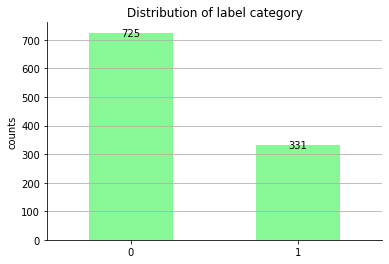

In [81]:
displayBarChart(df['label'])

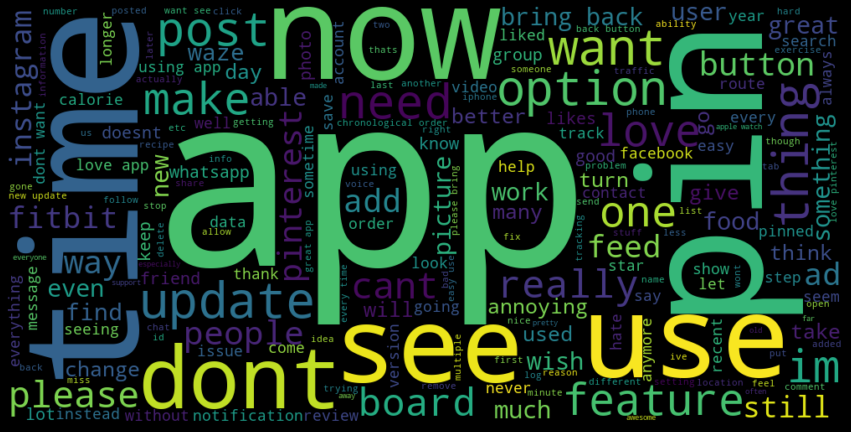

In [82]:
displayWordCloud(0) # Functional requirements wordcloud.

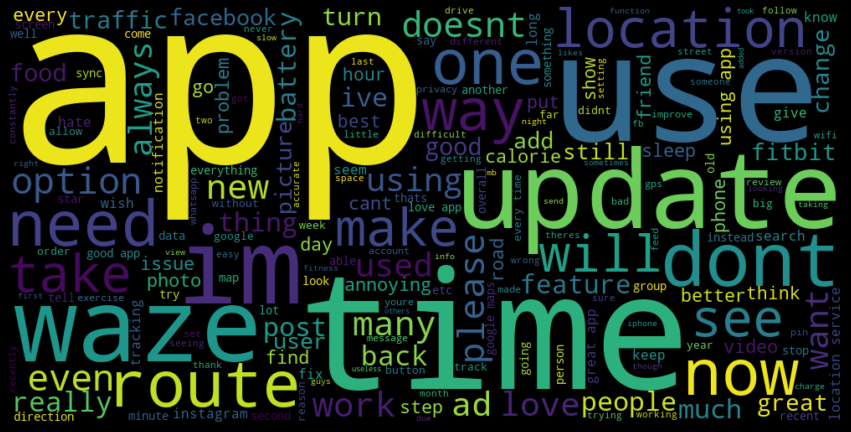

In [83]:
displayWordCloud(1) # Non-Functional requirements wordcloud.

## Pre-processing data

In this section we'll pre-process the data. 
Since a lot of pre-processing steps already have been done in the C++ program we only have to do the following things: 

 * Remove plural;
   * Makes it easy to determine the same word as plural. This is done by the porter stemmer.
 * Stemming with porter; 
   * Refactors `walking` to `walk`. 
 * Remove stop words;
   * Remove natural english stop words. Those words doesn't give away information.
 * Remove unnecesary words from wordcloud. 
   * 'update', 'app', 'time', 'iphone', 'phone', 'use'


In [84]:
# Load the english stopwords
sw = stopwords.words("english")

In [85]:
# Split the text column from label column to easly pre-process.
textColumn = df['text'] 
labelColumn = df['label'].tolist()

In [98]:
# The corpus of the reviews, the place where all the pre-processed data will be.
corpus = cleanReviews(textColumn, False)

## Train, validate and test sets

In [99]:
# Split text data into 70, 15, 15 ratio.
textTrain, textTest, textValidate  = numpy.split(corpus, [int(.7*len(corpus)), int(.85*len(corpus))])

# Split label data into 70, 15, 15 ratio.
labelTrain, labelTest, labelValidate  = numpy.split(labelColumn, [int(.7*len(labelColumn)), int(.85*len(labelColumn))])

In [100]:
# Training set sneak peak.
textTrain[1:5]

array(['always something never get righti see stuff day im suddenly stuff week ado need order stuff pop day',
       'spent hour trying upload photo would work uploading silly come load post every add photo album add sit uploading load separately please sort',
       'completely useless trying upload photo freeze screen camera roll selection freeze even photo increment',
       'losing patience tolerance fb sure fb dictate status updatesposts see order etc news feed random selection post recent feed worthless doesnt show recent post connection view news feed recent hope see everything continue miss post friend etc course merchant ad suggested post readily available news feed see random post ad post another ad'],
      dtype='<U1119')

## Feature engineering, TF-IDF Vector

In this section we will abstract from the text some features, and parse the text to number. We'll do this by converting the text to a `Term Frequency-Inverse Document Frequency`. This approach represents the relative importance of a term in a document.

In [102]:
# Create the vectorizer. min_df to get rid of extremly rare words. max_df to get rid of the extremly often used words.
vectorizer = TfidfVectorizer(min_df = 5, max_df = .75)
# Use bag of words.
countVectorizer = CountVectorizer()

# Setup training data and test data.
trainDataTFIDF = vectorizer.fit_transform(textTrain).toarray()
validateDataTFIDF = vectorizer.transform(textValidate).toarray()
testDataTFIDF = vectorizer.transform(textTest).toarray()

print('TFIDF \n')
print('Number of features = {}'.format(len(vectorizer.vocabulary_)))
print('Train shape = ', trainDataTFIDF.shape)
print('Validate shape = ', validateDataTFIDF.shape)
print('Test shape = ', testDataTFIDF.shape)

trainDataCV = countVectorizer.fit_transform(textTrain).toarray()
validateDataCV = countVectorizer.transform(textValidate).toarray()
testDataCV = countVectorizer.transform(textTest).toarray()

print('\nCV \n')
print('Number of features = {}'.format(len(countVectorizer.vocabulary_)))
print('Train shape = ', trainDataCV.shape)
print('Validate shape = ', validateDataCV.shape)
print('Test shape = ', testDataCV.shape)

# Take a look at the tfidf matrix. 
frequencyMatrix = pandas.DataFrame(trainDataTFIDF, columns = vectorizer.get_feature_names())
frequencyMatrix.head()

TFIDF 

Number of features = 679
Train shape =  (739, 679)
Validate shape =  (159, 679)
Test shape =  (158, 679)

CV 

Number of features = 3013
Train shape =  (739, 3013)
Validate shape =  (159, 3013)
Test shape =  (158, 3013)


ability  able  absolutely  access  account  accurate  active  activity  \
0      0.0   0.0         0.0     0.0      0.0       0.0     0.0       0.0   
1      0.0   0.0         0.0     0.0      0.0       0.0     0.0       0.0   
2      0.0   0.0         0.0     0.0      0.0       0.0     0.0       0.0   
3      0.0   0.0         0.0     0.0      0.0       0.0     0.0       0.0   
4      0.0   0.0         0.0     0.0      0.0       0.0     0.0       0.0   

   actual  actually  ...  worth     would  writing  wrong  yall  year  yet  \
0     0.0       0.0  ...    0.0  0.000000      0.0    0.0   0.0   0.0  0.0   
1     0.0       0.0  ...    0.0  0.000000      0.0    0.0   0.0   0.0  0.0   
2     0.0       0.0  ...    0.0  0.141543      0.0    0.0   0.0   0.0  0.0   
3     0.0       0.0  ...    0.0  0.000000      0.0    0.0   0.0   0.0  0.0   
4     0.0       0.0  ...    0.0  0.000000      0.0    0.0   0.0   0.0  0.0   

   youre  youve  zoom  
0    0.0    0.0   0.0  
1    0.0    0.0   0.0  
2    0.0    0.0   0.0  
3    0.0    0.0   0.0  
4    0.0    0.0   0.0  

[5 rows x 679 columns]

## Modeling

In this section we'll make our machine learning models. We'll fit the models and determine their correctness. 

The models that we are going to validate are: 
  * Naive Bayes Classifier - Multinomial Model
  * Linear Support Vector Machine
  * Logistic Regression

In [103]:
print('------ Bag of words engineering ------')
bayesTrainedModel = bayesModel(trainDataCV, labelTrain, validateDataCV, labelValidate)

print('------ TFIDF engineering ------')
bayesModel(trainDataTFIDF, labelTrain, validateDataTFIDF, labelValidate)

------ Bag of words engineering ------
GAUSSIAN NAIVE BAYES: 

Acurracy score: 0.7547169811320755

              precision    recall  f1-score   support

           0       0.75      0.98      0.85       114
           1       0.80      0.18      0.29        45

    accuracy                           0.75       159
   macro avg       0.78      0.58      0.57       159
weighted avg       0.77      0.75      0.69       159

------ TFIDF engineering ------
GAUSSIAN NAIVE BAYES: 

Acurracy score: 0.7169811320754716

              precision    recall  f1-score   support

           0       0.72      0.99      0.83       114
           1       0.50      0.02      0.04        45

    accuracy                           0.72       159
   macro avg       0.61      0.51      0.44       159
weighted avg       0.66      0.72      0.61       159



MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [105]:
print('------ Bag of words engineering ------')
logisticRegressionModel(trainDataCV, labelTrain, validateDataCV, labelValidate)

print('------ TFIDF engineering validate data------')
logisticRegressionModel(trainDataTFIDF, labelTrain, validateDataTFIDF, labelValidate)

------ Bag of words engineering ------
LOGISTIC REGRESSION: 

Acurracy score: 0.6666666666666666

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       114
           1       0.38      0.27      0.31        45

    accuracy                           0.67       159
   macro avg       0.56      0.55      0.55       159
weighted avg       0.64      0.67      0.65       159

------ TFIDF engineering validate data------
LOGISTIC REGRESSION: 

Acurracy score: 0.6477987421383647

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       114
           1       0.38      0.38      0.38        45

    accuracy                           0.65       159
   macro avg       0.57      0.57      0.57       159
weighted avg       0.65      0.65      0.65       159



LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=1,
                   penalty='l2', random_state=None, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

## Final requirements elicitation

According to all the classifers' results, we've chosen to pick the support vector machine for our whole dataset. 

We will load the whole unlabled dataset, and then apply it to our model. We will save the results to a file called `model-2-results` and in the file `combine-results` will the results be combined. 

In [106]:
totaldf = pandas.read_csv('data/input/unlabelledDataset.csv') # Read the unlabled dataset.
totaldf.head()

Unnamed: 0  app_name    user_id          user_name                 date  \
0           1  Facebook   46172917  Christophernaylor  2017-06-30 00:00:00   
1           2  Facebook  111322700           aenewman  2017-06-30 00:00:00   
2           3  Facebook   49523188         Mamankajuj  2017-06-30 00:00:00   
3           4  Facebook  348391269        Upsetuser99  2017-06-30 00:00:00   
4           5  Facebook  109196171         Bugbugkrys  2017-06-30 00:00:00   

  country version  score         topic  \
0  Canada      99      1  Fix this app   
1  Canada      96      1       Really?   
2  Canada      99      5        Useful   
3  Canada      99      1         Icons   
4  Canada      96      1      Annoying   

                                              review  \
0  You continually update this app and increase t...   
1  The new comments section on videos is the wors...   
2                                             Useful   
3  I don't enjoy that the icons on the bottom for...   
4  Updated the app despite my gut feeling not too...   

                                                 url  review_id  
0  https://itunes.apple.com/WebObjects/MZStore.wo...          2  
1  https://itunes.apple.com/WebObjects/MZStore.wo...          3  
2  https://itunes.apple.com/WebObjects/MZStore.wo...          4  
3  https://itunes.apple.com/WebObjects/MZStore.wo...          5  
4  https://itunes.apple.com/WebObjects/MZStore.wo...          6

In [107]:
# Concat the topic and review column to text column.
totaldf['text'] = totaldf['topic'].apply(str) + ' ' + totaldf['review'].apply(str) 

# Generate a corpus and tfidf to fed in the model.
corpus = cleanReviews(totaldf['text'].apply(str), True)
bow = countVectorizer.transform(corpus).toarray()

In [108]:
# Make predictions with the svm. 
labels = bayesTrainedModel.predict(bow)

# Represent the labels as numbers (functional: 0, non-functional: 1).
textLabels = numpy.where(labels == 0, 'functional', 'non-functional')

In [109]:
# Create a new dataframe with the labels and reviews
result = pandas.DataFrame(data= {'labels': textLabels, 'review': totaldf['text']})
result.head()

labels                                             review
0  non-functional  Fix this app You continually update this app a...
1      functional  Really? The new comments section on videos is ...
2      functional                                      Useful Useful
3      functional  Icons I don't enjoy that the icons on the bott...
4      functional  Annoying Updated the app despite my gut feelin...

### Data visualization

As you can see in the bar chart below are the labels not really equally distributed. 

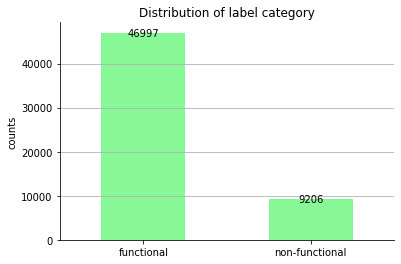

In [110]:
displayBarChart(result['labels'])

In [111]:
# Write result to csv file.
result.to_csv('data/output/model-2-results.csv', index = False)